In [2]:
#import all relevant packages
import torch, torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.nn import functional as F

s=9
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data wrangling

In [3]:
# data wrangling: load MNIST
MNIST_transform = transforms.Compose([
    transforms.ToTensor(),
])


MNIST_train = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=True,
        download=True,
        transform=MNIST_transform)


MNIST_test = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform)


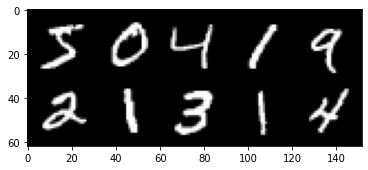

In [4]:
# have a look at the data to verify
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()

images = MNIST_train.data[:10].view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(images, nrow=5))


In [5]:
mnist_train_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_train,
    batch_size=128,
    shuffle=True
)

mnist_test_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_test,
    batch_size=128,
    shuffle=False,
)


# Training routine

In [6]:
#set up the network
"""
def NN(num_classes=10):
    
    features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Conv2d(32, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Flatten(),
        torch.nn.Linear(4 * 4 * 32, num_classes)
    )
    return(features)
"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.maxpool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(32, 32, 5)
        #self.maxpool2 = nn.MaxPool2d(2, 2)
        #self.fc1 = nn.Linear(4*4*32, 10)
        
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        #x = F.relu(self.conv1(x))
        #x = self.maxpool(F.relu(self.conv2(x)))
        #x = F.relu(self.conv2(x))
        #x = x.view(-1, 4*4*32)
        return x


In [7]:
#set up the training routine
mnist_model = Net()
loss_function = nn.CrossEntropyLoss()

mnist_train_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=1e-3, weight_decay=5e-4)
#dont use SGD, it is way worse than Adam here
#MNIST_PATH = "MNIST_weights_seed={}.pth".format(s)
#print(MNIST_PATH)

In [8]:
# Write the training routine and save the model at FMNIST_PATH

def train(verbose=False, num_iter=5):
    max_len = len(mnist_train_loader)
    for iter in range(num_iter):
        for batch_idx, (x, y) in enumerate(mnist_train_loader):
            output = mnist_model(x)

            accuracy = get_accuracy(output, y)

            loss = loss_function(output, y)
            loss.backward()
            mnist_train_optimizer.step()
            mnist_train_optimizer.zero_grad()

            if verbose:
                if batch_idx % 10 == 0:
                    print(
                        "Iteration {}; {}/{} \t".format(iter, batch_idx, max_len) +
                        "Minibatch Loss %.3f  " % (loss) +
                        "Accuracy %.0f" % (accuracy * 100) + "%"
                    )

    print("saving model at: {}".format(MNIST_PATH))
    torch.save(mnist_model.state_dict(), MNIST_PATH)

In [9]:
#predict in distribution
MNIST_PATH = "../trained_weights/MNIST_weights_seed={}.pth".format(s)

mnist_model = Net()
print("loading model from: {}".format(MNIST_PATH))
mnist_model.load_state_dict(torch.load(MNIST_PATH), strict = False)
mnist_model.eval()
"""acc = []

max_len = len(mnist_test_loader)
for batch_idx, (x, y) in enumerate(mnist_test_loader):
        output = mnist_model(x)
        accuracy = get_accuracy(output, y)
        if batch_idx % 10 == 0:
            print(
                "Batch {}/{} \t".format(batch_idx, max_len) + 
                "Accuracy %.0f" % (accuracy * 100) + "%"
            )
        acc.append(accuracy)
    
avg_acc = np.mean(acc)
print('overall test accuracy on MNIST: {:.02f} %'.format(avg_acc * 100))
"""

loading model from: ../trained_weights/MNIST_weights_seed=9.pth


'acc = []\n\nmax_len = len(mnist_test_loader)\nfor batch_idx, (x, y) in enumerate(mnist_test_loader):\n        output = mnist_model(x)\n        accuracy = get_accuracy(output, y)\n        if batch_idx % 10 == 0:\n            print(\n                "Batch {}/{} \t".format(batch_idx, max_len) + \n                "Accuracy %.0f" % (accuracy * 100) + "%"\n            )\n        acc.append(accuracy)\n    \navg_acc = np.mean(acc)\nprint(\'overall test accuracy on MNIST: {:.02f} %\'.format(avg_acc * 100))\n'

## visualize the activations
* of first and second conv-layer

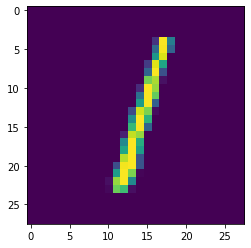

In [10]:
plt.imshow(MNIST_test.data[2])

In [11]:
print(mnist_model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [12]:
#testimg = MNIST_test.data[55].reshape(1, 28, 28, 1)


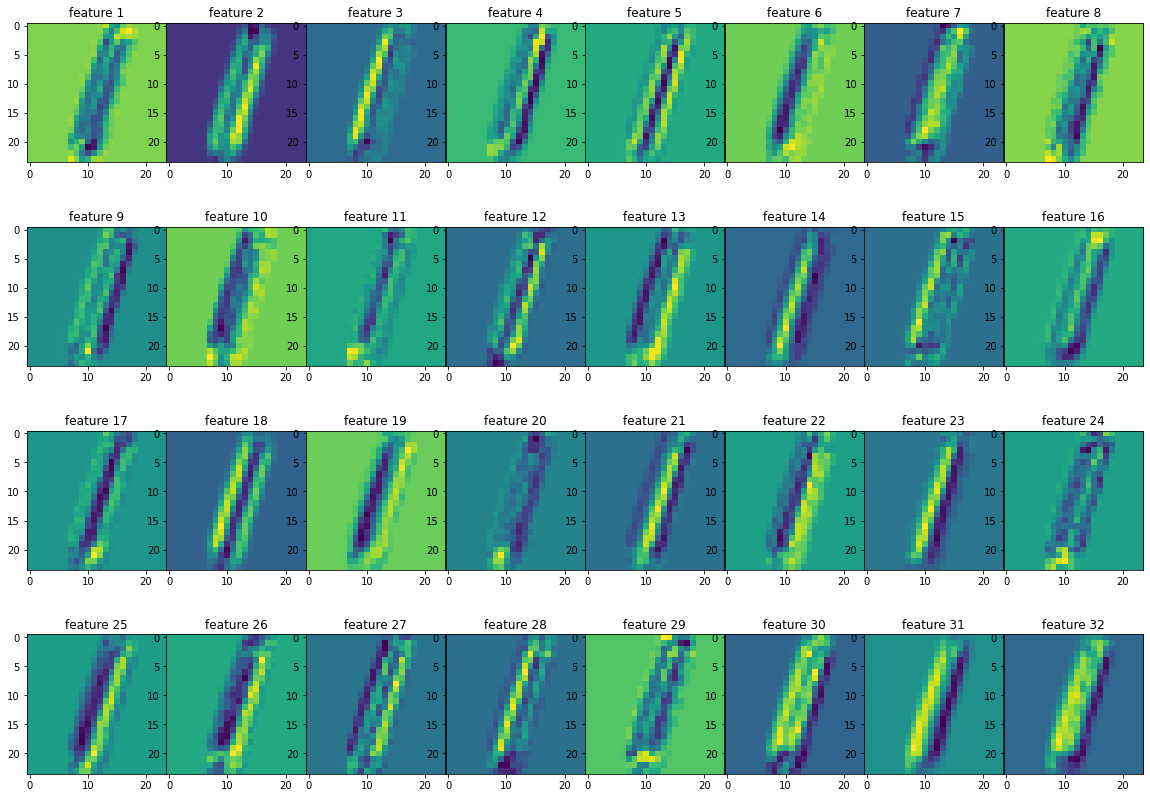

In [19]:
#activations = mnist_model(testimg)
#from random import randint
#random = randint(0, 1000)

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


mnist_model.conv1.register_forward_hook(get_activation('conv1'))
data, _ = MNIST_test[2]
data.unsqueeze_(0)
output = mnist_model(data)

act = activation['conv1'].squeeze()
#subplot setup and activation plots
fig, axarr = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axarr = axarr.ravel()
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx], interpolation='nearest')
    axarr[idx].set_title('feature {}'.format(idx +1))

#one can also plot the kernels of the conv1 layer:
#kernels = mnist_model.conv1.weight.detach()
#for idx in range(kernels.size(0)):
#    axarr[idx].imshow(kernels[idx].squeeze())


In [14]:
"""
mnist_model.conv2.register_forward_hook(get_activation('conv2'))
data, _ = MNIST_test[55]
data.unsqueeze_(0)
output = mnist_model(data)

act = activation['conv2'].squeeze()
#subplot setup and activation plots
fig, axarr = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axarr = axarr.ravel()
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx], interpolation='nearest')
    axarr[idx].set_title('feature {}'.format(idx +1))
"""

"\nmnist_model.conv2.register_forward_hook(get_activation('conv2'))\ndata, _ = MNIST_test[55]\ndata.unsqueeze_(0)\noutput = mnist_model(data)\n\nact = activation['conv2'].squeeze()\n#subplot setup and activation plots\nfig, axarr = plt.subplots(4,8, figsize=(20, 15))\nfig.subplots_adjust(hspace = .001, wspace=.001)\naxarr = axarr.ravel()\nfor idx in range(act.size(0)):\n    axarr[idx].imshow(act[idx], interpolation='nearest')\n    axarr[idx].set_title('feature {}'.format(idx +1))\n"

In [21]:
#for i in range(10):
#print(output_flattend.size())
#data, _ = MNIST_test[2]
#data.unsqueeze_(0)
#output = mnist_model(data)
#output_flattend = output.view(-1, 4*4*32)
#pre_activation = output_flattend.detach().numpy()
#plt.imshow(pre_activation, cmap='gist_stern',extent=[0,512,0,1],  aspect='auto')
#ax = plt.gca()
#ax.set_xticks(np.arange(1, 512, 32));
#ax.set_xticklabels(np.arange(1, 32, 2));
#ax.set_title('input of linear layer, seed {}'.format(s))
#plt.colorbar()
#plt.tight_layout()
#plt.show()
    #plt.savefig('linear_seed1000={}'.format(s))

    #print(pre_activation)
    

torch.Size([1, 32, 12, 12])


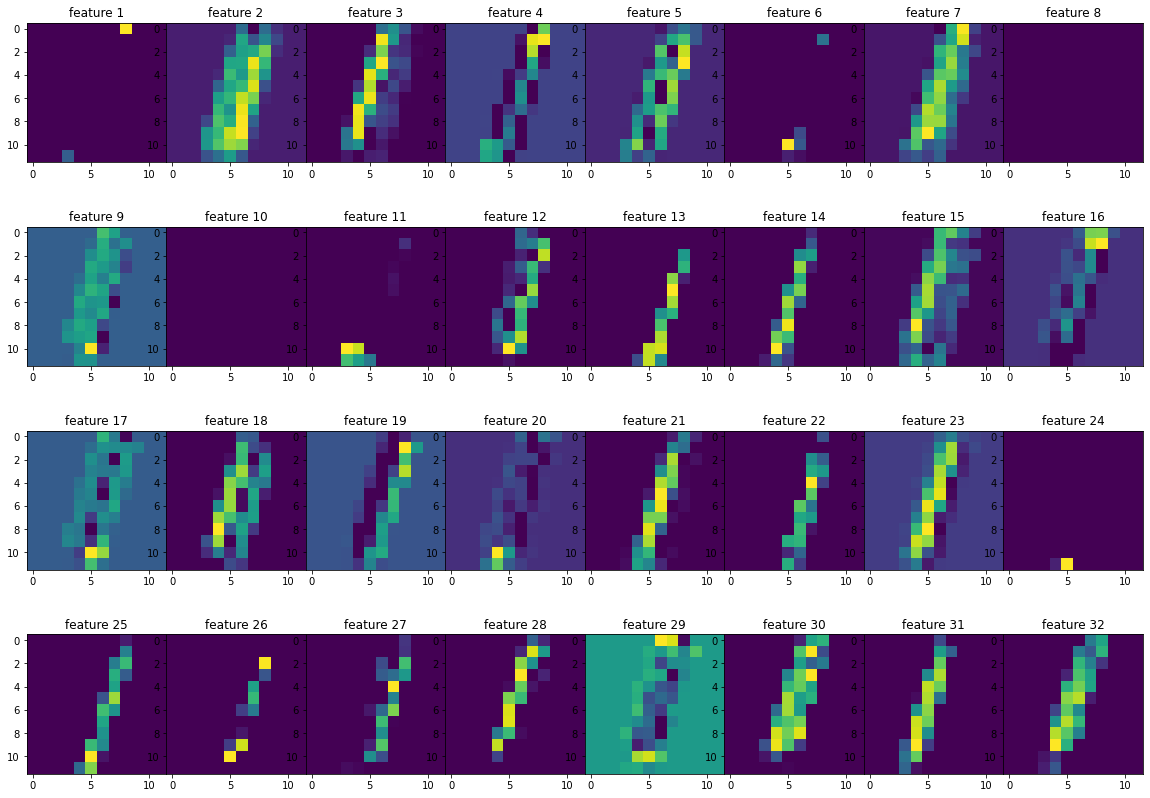

In [17]:
data, _ = MNIST_test[2]
data.unsqueeze_(0)
output = mnist_model(data)
print(output.size())
#print(output[0][31])
inputfeed = output.detach().numpy()
fig, axarr = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axarr = axarr.ravel()
for idx in range(output.size(1)):
    axarr[idx].imshow(inputfeed[0][idx], interpolation='nearest')
    axarr[idx].set_title('feature {}'.format(idx +1))

In [22]:
print(torch.__version__)
import sys
print(sys.version)


1.5.0
3.7.2 (default, Dec 29 2018, 00:00:04) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
